# Setup

## Easy Install

In [55]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade
# %pip install graphviz
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost

## Imports and Variables

In [56]:
from os import path, getcwd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import VarianceThreshold

# Tree Visualisation
from sklearn.tree import export_graphviz
# from IPython.display import Image
import graphviz

subjects = [102, 104, 105, 107, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['1','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']
results_file = 'Results.xlsx'
Notes = 'Normalizer Normalization'



Alpha variability and all with posterior features --> see performance,  
Then include behavioural features: 'Reaction time Mean', 'Reaction time variability',and see how it performs

Feature ranking algorithms (top 5, top 10 features)
correlation matrix between features to identify important ** try first

## Data Collection

In [57]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subData_TR = subData['TR'][0,0]
    subData_TUR = subData['TUR'][0,0]
    subDF_TR = pd.DataFrame(subData_TR, columns = col)
    subDF_TUR = pd.DataFrame(subData_TUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDF_TR,subDF_TUR])
    else:
        totalDF = pd.concat([totalDF, subDF_TR])
        totalDF = pd.concat([totalDF, subDF_TUR])

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Excluded from analysis.
# totalDF.fillna(0, inplace=True)

totalDF.reset_index(drop=True, inplace=True)
# print(totalDF)


## Feature Selection
Feature selection is for determining the most important features in our data. We compared all features, the alpha + posterior features, and finally, the alpha + posterior + behavioural features before using the built-in feature analysis (suggested by Sarah).  
[There are many types of feature selection techniques](https://youtu.be/LTE7YbRexl8?si=xW9kJt1lciKEKwAW). 
1. Filter-based techniques:
    - Correlation
    - Variance threshold
    - Chi squared
    - Anova
    - Information Gain
2. Wrapper techniques:
    - Recursive Feature Elimination (RFE)
3. Embed techniques
    - L1 & L2
    - Pruning/Decision trees

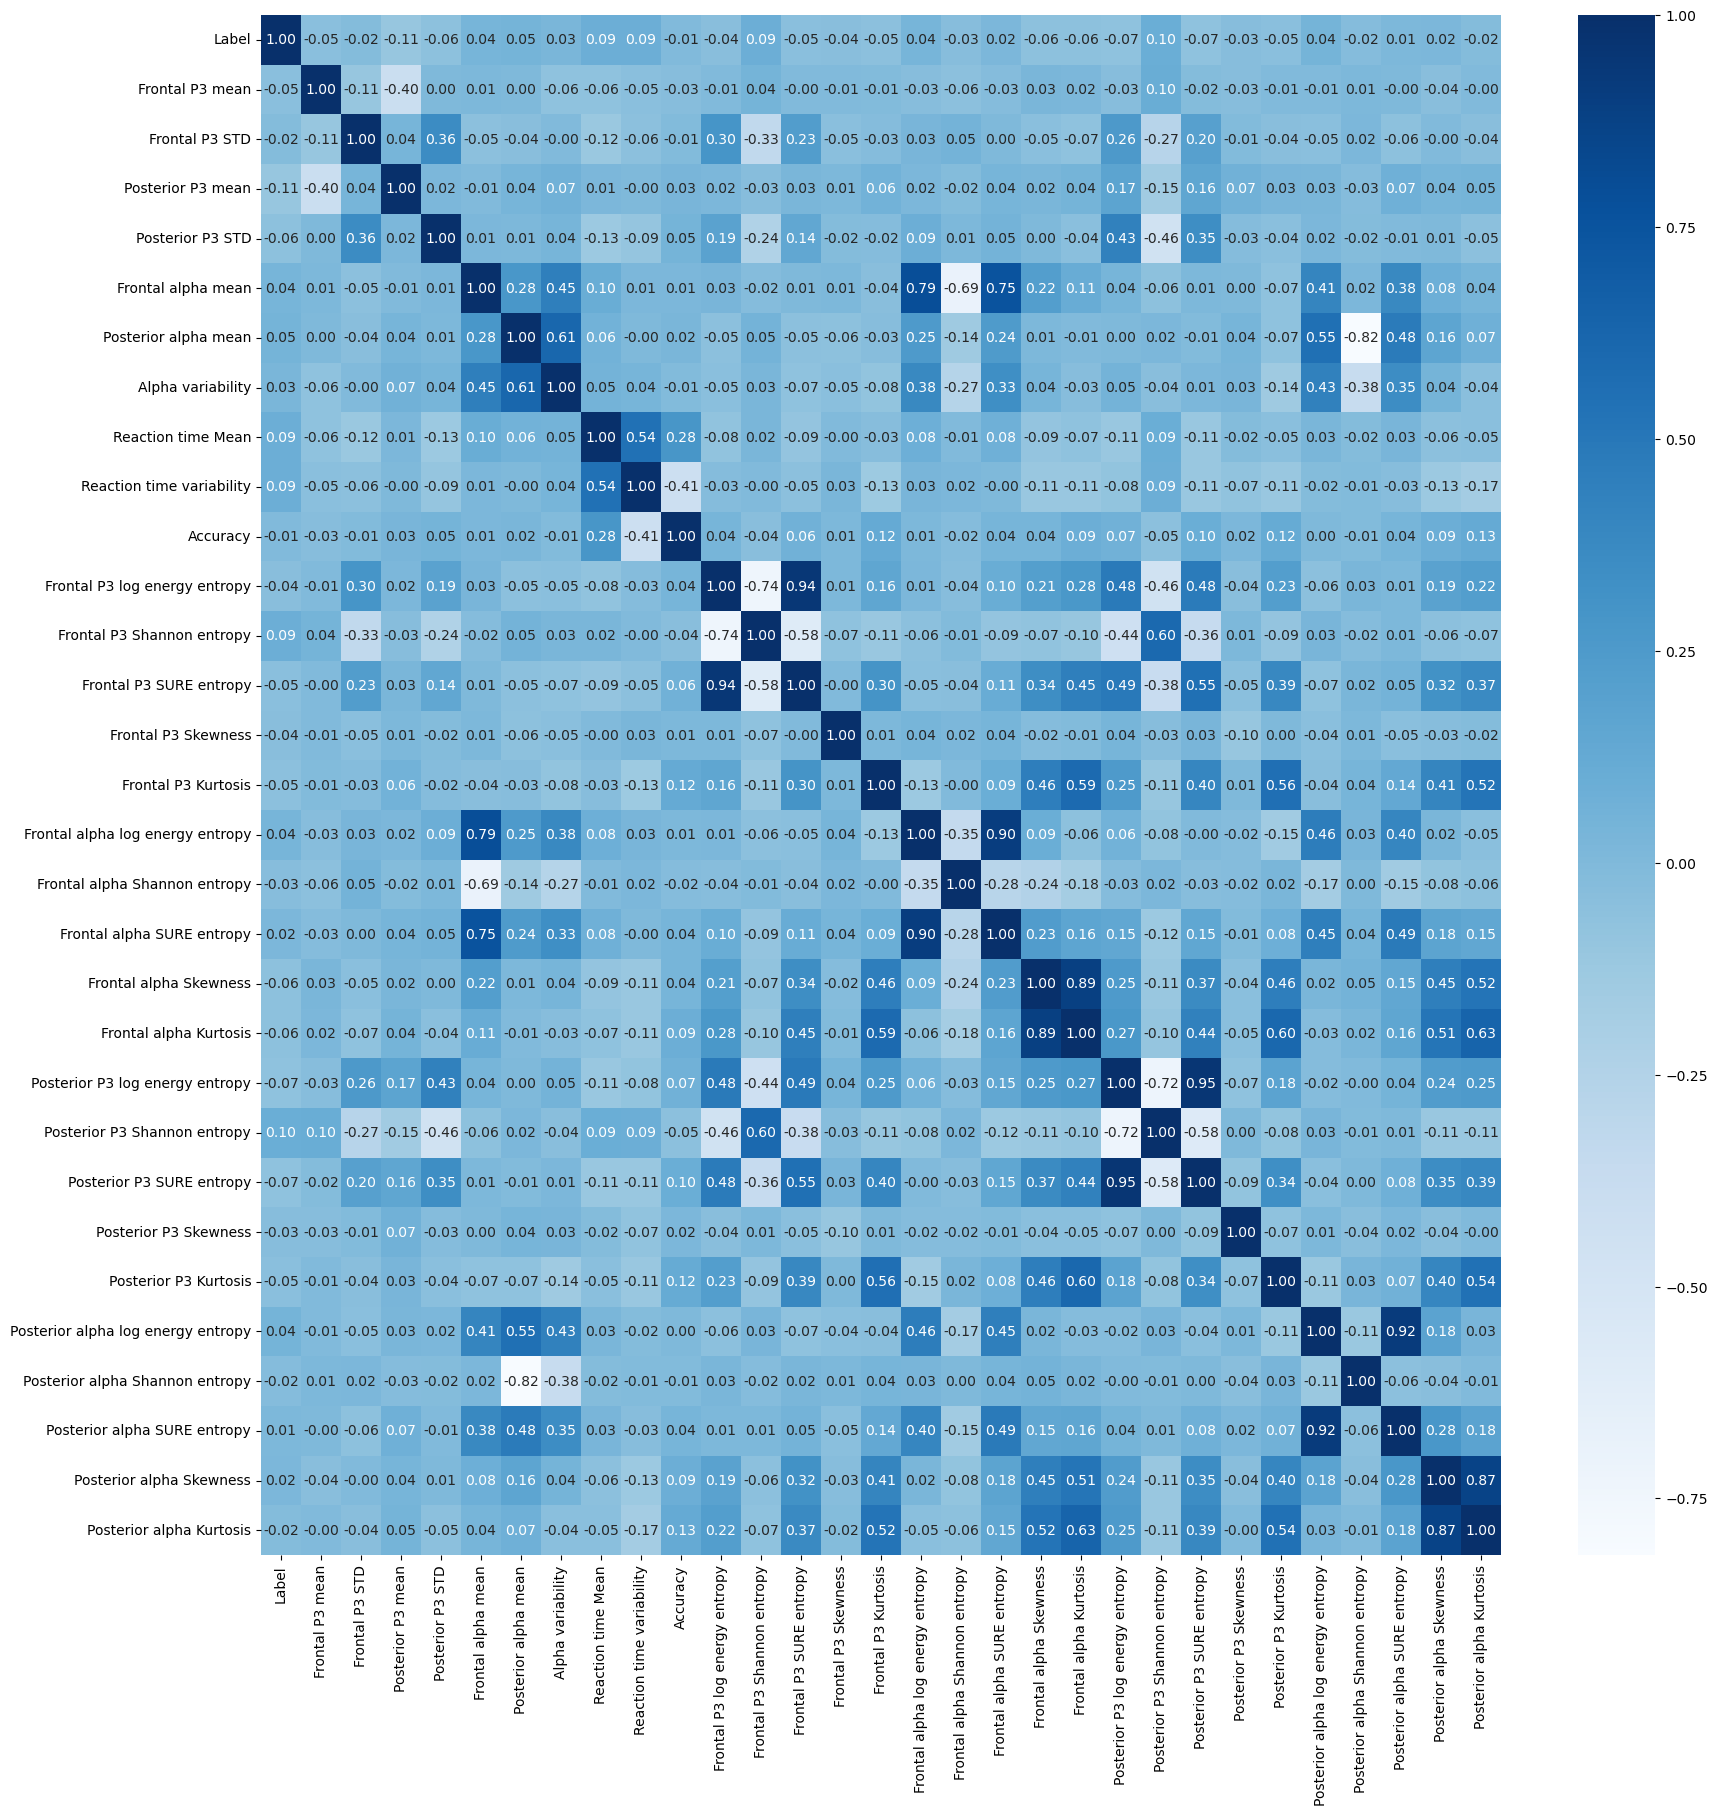

In [59]:
ap_features = totalDF.iloc[:, [3,6,7,9,10,13,24,25,26,27,28,29,30,31,32,33]]
apb_features = totalDF.iloc[:, [3,6,7,9,10,11,12,13,24,25,26,27,28,29,30,31,32,33]]
all_features = totalDF.iloc[:,3:]

# Correlation Matrix:
corrMat = all_features.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMat, annot=True, cmap='Blues', fmt=".2f")
columns_to_drop = ['Frontal P3 log energy entropy','Frontal alpha log energy entropy', 'Frontal alpha Kurtosis', 
                   'Posterior P3 log energy entropy', 'Posterior alpha log energy entropy', 'Posterior alpha Kurtosis']
uncorr_features = all_features.drop(columns=columns_to_drop, axis=1)
sns.heatmap(uncorr_features.corr(), annot=True, cmap='Blues', fmt=".2f")




# 'AP' = alpha + posterior, 'APB' = alpha + posterior + behvaioural, 'all' = all features
Select_features = 'uncorr'
if Select_features == 'AP':
    target_Data = ap_features
elif Select_features == 'APB':
    target_Data = apb_features
elif Select_features == 'uncorr':
    target_Data = uncorr_features
else: 
    target_Data = all_features
    


# print(target_Data.columns)
X = target_Data.iloc[:,1:]
Y = target_Data.Label
Y = Y - 1
# Verify that Labels contain only 0 and 1:
# print(targetData.Label.unique())




## Split and Normalize

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

normalized = 2
sc = StandardScaler()
mms = MinMaxScaler()
ns = Normalizer()
if normalized == 1:
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
elif normalized == 2:
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
elif normalized == 3:
    X_train = ns.fit_transform(X_train)
    X_test = ns.transform(X_test)

# K-Fold Cross Validation

## Variables init
Choose what type of KFold, which measures you would like, what info you would like to store in results. Some resources:
- [svm](https://www.youtube.com/watch?v=efR1C6CvhmE)
- [Gradient Boosting info](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
index = []
scores = {"Accuracy": [], "BA": [], "Matt_Corr_Coef": [], "Cnf_Matr": None, "AUC": []}
results = {'Timestamp': [], 'Features': Select_features, 'Normalized': normalized,'CrossVal': type(kf).__name__, 'model': [], "Accuracy": [], "BA": [], "Matt_Corr_Coef": [], 'AUC': [], 'CnfM00': [], 'CnfM01': [], 
           'CnfM10': [], 'CnfM11': [], 'Notes': Notes}
scoring = ['accuracy', 'balanced_accuracy', 'matthews_corrcoef']   
# Fill this with the models you would like to test:
regressors = [LogisticRegression(max_iter=1800, random_state=42), RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42), SVC(random_state=42), KNeighborsClassifier(), 
              XGBClassifier(random_state=42), LGBMClassifier(random_state=42), CatBoostClassifier(random_state=42)]
# regressors = [CatBoostClassifier(random_state=42), RandomForestClassifier(random_state=42), LGBMClassifier(random_state=42), XGBClassifier(random_state=42)]

In [ ]:
for regressor in regressors:
    for train_index, test_index in kf.split(X, Y):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = Y.iloc[train_index], Y.iloc[test_index]

        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train_kf, y_train_kf)
        
        
        cv_results = cross_validate(regressor, X_train_res, y_train_res, cv=5, scoring=scoring)
        scores["Accuracy"].append(cv_results['test_accuracy'].mean())
        scores["BA"].append(cv_results['test_balanced_accuracy'].mean())
        scores["Matt_Corr_Coef"].append(cv_results['test_matthews_corrcoef'].mean())
        cnf_matrix = metrics.confusion_matrix(y_test_kf, regressor.fit(X_train_res, y_train_res).predict(X_test_kf))
        if scores["Cnf_Matr"] is None:
            scores["Cnf_Matr"] = cnf_matrix
        else:
            scores["Cnf_Matr"] = np.mean(np.array([scores['Cnf_Matr'], cnf_matrix]), axis=0 )
        scores["AUC"].append(metrics.roc_auc_score(y_test_kf, regressor.fit(X_train_res, y_train_res).predict(X_test_kf)))
        
        
    print('\n')
    print(type(regressor).__name__)
    results['model'].append(type(regressor).__name__)
    
    for key in scores:
        if key != "Cnf_Matr":
            print(key, ":", np.mean(scores[key]))
            results[key].append(np.mean(scores[key]))
    print("Cnf_Matr: \n", scores["Cnf_Matr"])
    print("\n")    
    
    results['CnfM00'].append(scores["Cnf_Matr"][0][0])
    results['CnfM01'].append(scores["Cnf_Matr"][0][1])
    results['CnfM10'].append(scores["Cnf_Matr"][1][0])
    results['CnfM11'].append(scores["Cnf_Matr"][1][1])
    results['Timestamp'].append(pd.Timestamp.now())
    
    scores = {"Accuracy": [], "BA": [], "Matt_Corr_Coef": [], "Cnf_Matr": None, "AUC": []}
        

c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




LogisticRegression
Accuracy : 0.5277831165496385
BA : 0.5277235772357722
Matt_Corr_Coef : 0.056198568957304254
AUC : 0.4735748028584371
Cnf_Matr: 
 [[17.9375 17.3125]
 [55.8125 46.0625]]




RandomForestClassifier
Accuracy : 0.7795763342773168
BA : 0.7798584763625415
Matt_Corr_Coef : 0.5719234966181541
AUC : 0.4890222887835002
Cnf_Matr: 
 [[ 5.5    29.75  ]
 [24.5625 77.3125]]




GradientBoostingClassifier
Accuracy : 0.707813856052671
BA : 0.708124059018368
Matt_Corr_Coef : 0.42968989192887397
AUC : 0.4784828188701223
Cnf_Matr: 
 [[ 7.9375 27.3125]
 [34.     67.875 ]]




SVC
Accuracy : 0.5122609606464162
BA : 0.5118157181571815
Matt_Corr_Coef : 0.040016267873275266
AUC : 0.4994030285381479
Cnf_Matr: 
 [[31.125   4.125 ]
 [90.3125 11.5625]]




KNeighborsClassifier
Accuracy : 0.6449613077589536
BA : 0.6450948509485095
Matt_Corr_Coef : 0.30540645127535804
AUC : 0.49728665723715226
Cnf_Matr: 
 [[16.5    18.75  ]
 [49.4375 52.4375]]




XGBClassifier
Accuracy : 0.7518054470251588
BA : 

## Record Results
Add these Results and Test Conditions to Results.xlsx. Will delete duplicate results within conditions.

In [ ]:
df_newScores = pd.DataFrame(results)
print(df_newScores)
df_existingRecord = pd.read_excel(results_file)
df_combined = pd.concat([df_existingRecord, df_newScores], ignore_index=True)
df_combined.drop_duplicates(subset=['Features', 'model', "Accuracy", "BA", "Matt_Corr_Coef", 'AUC', 'CnfM00', 'CnfM01', 'CnfM10', 'CnfM11', 'Notes'], keep='last', inplace = True)
df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
df_combined.to_excel(results_file, index=False)

                   Timestamp Features  Normalized         CrossVal  \
0 2024-05-31 12:03:32.472417      all           3  StratifiedKFold   
1 2024-05-31 12:03:46.034145      all           3  StratifiedKFold   
2 2024-05-31 12:04:13.728977      all           3  StratifiedKFold   
3 2024-05-31 12:04:15.068815      all           3  StratifiedKFold   
4 2024-05-31 12:04:16.274952      all           3  StratifiedKFold   
5 2024-05-31 12:04:19.775702      all           3  StratifiedKFold   
6 2024-05-31 12:04:21.639752      all           3  StratifiedKFold   
7 2024-05-31 12:06:28.828070      all           3  StratifiedKFold   

                        model  Accuracy        BA  Matt_Corr_Coef       AUC  \
0          LogisticRegression  0.527783  0.527724        0.056199  0.473575   
1      RandomForestClassifier  0.779576  0.779858        0.571923  0.489022   
2  GradientBoostingClassifier  0.707814  0.708124        0.429690  0.478483   
3                         SVC  0.512261  0.511816    